## Analyzing Individual Datasets for facial expression and hand gesture

In [1]:
from sklearn.model_selection import train_test_split
import cv2
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML, Video
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import numpy as np

## Facial Expression Detection

In [ ]:
train_folder = 'facial_expressions_mnist/train'
test_folder = 'facial_expressions_mnist/test'

In [ ]:
# Function to load images from a folder
def load_images_from_folder(folder):
    images = []
    labels = []
    for emotion_folder in os.listdir(folder):
        label = emotion_folder
        for filename in os.listdir(os.path.join(folder, emotion_folder)):
            img = cv2.imread(os.path.join(folder, emotion_folder, filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
                labels.append(label)
    return images, labels


In [ ]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for emotion_folder in os.listdir(folder):
        emotion_folder_path = os.path.join(folder, emotion_folder)
        if os.path.isdir(emotion_folder_path):
            label = emotion_folder
            for filename in os.listdir(emotion_folder_path):
                img_path = os.path.join(emotion_folder_path, filename)
                if os.path.isfile(img_path): 
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        images.append(img)
                        labels.append(label)
    return images, labels

In [ ]:
# Load images and labels from train and test folders
train_images, train_labels = load_images_from_folder(train_folder)
test_images, test_labels = load_images_from_folder(test_folder)

# Convert lists to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Verify the shape of the datasets
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (28709, 48, 48)
Train labels shape: (28709,)
Test images shape: (7178, 48, 48)
Test labels shape: (7178,)


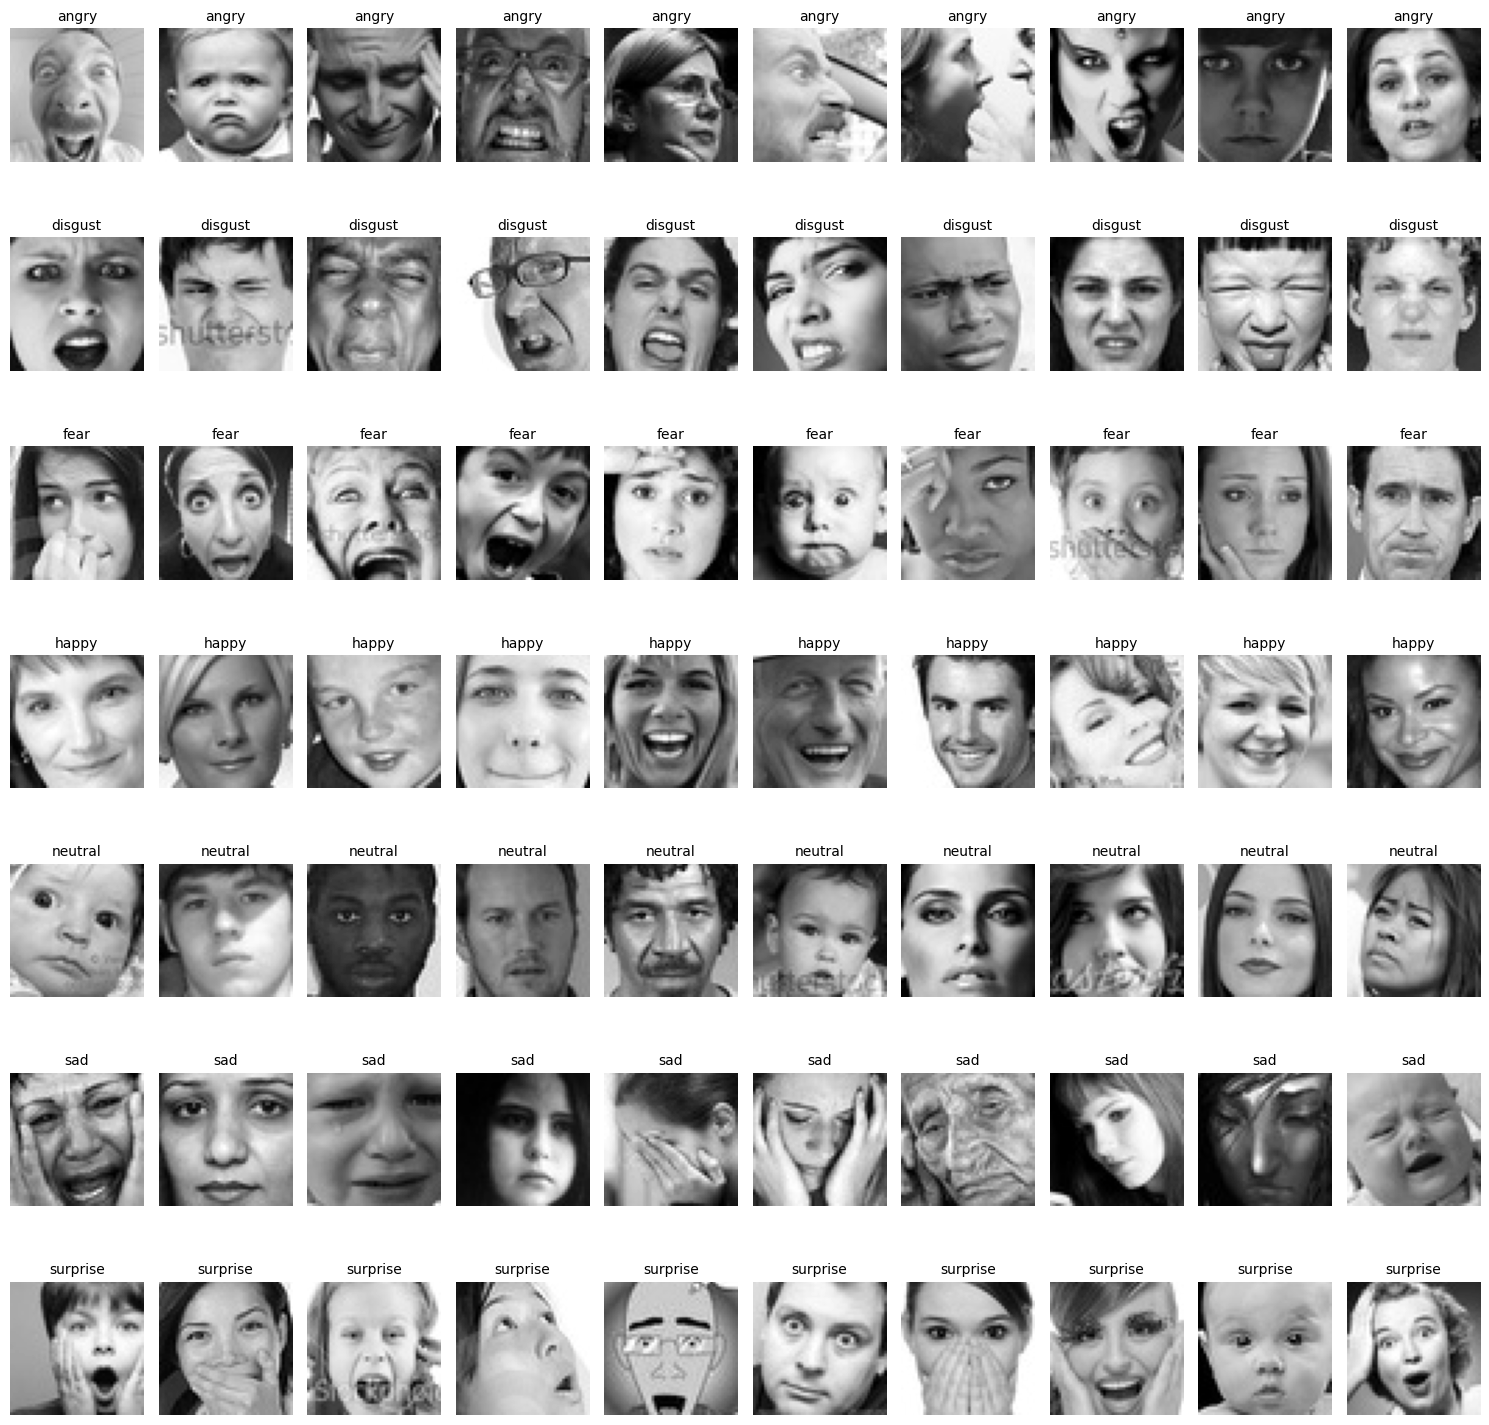

In [ ]:
num_samples = 10

class_names = np.unique(train_labels)
num_classes = len(class_names)
fig, ax = plt.subplots(num_classes, num_samples, figsize=(15, 15))
for i, class_name in enumerate(class_names):
    class_indices = np.where(train_labels == class_name)[0][:num_samples]
    for j, idx in enumerate(class_indices):
        ax[i,j].imshow(train_images[idx], cmap='gray')
        ax[i,j].axis('off')
        ax[i,j].set_title(class_name, fontsize=10)

plt.tight_layout()
plt.show()

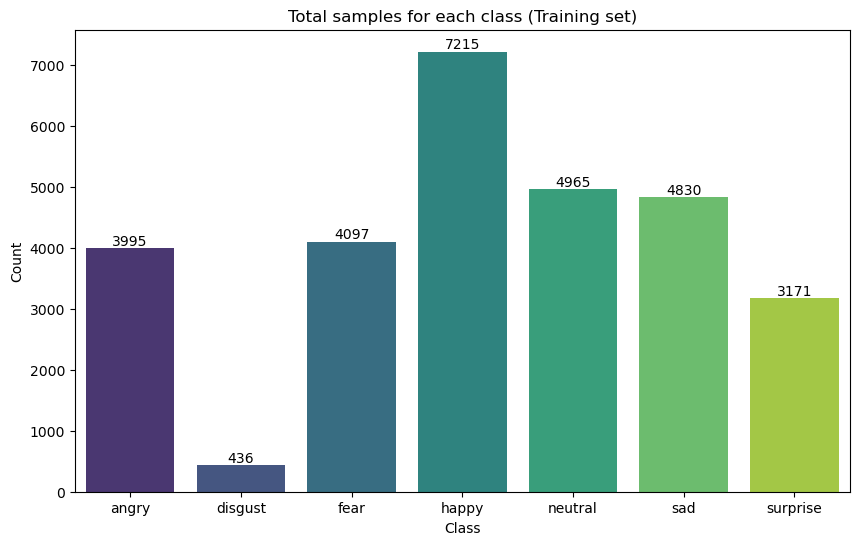

In [ ]:

unique, counts = np.unique(train_labels, return_counts=True)
train_class_counts = dict(zip(unique, counts))

plt.figure(figsize=(10, 6))  
sns.barplot(x=list(train_class_counts.keys()), y=list(train_class_counts.values()), palette='viridis')

plt.title("Total samples for each class (Training set)")
plt.xlabel("Class")
plt.ylabel("Count")

for index, value in enumerate(list(train_class_counts.values())):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()


# SMOTE

In [ ]:

disgust_indices = np.where(train_labels == "disgust")[0]
surprise_indices = np.where(train_labels == "surprise")[0]
indices_to_oversample = np.concatenate([disgust_indices, surprise_indices])


In [ ]:


def calculate_smote_percentage(current_count, target_count):

    if current_count >= target_count:
        return 0
    else:
        return ((target_count - current_count) / current_count) * 100

def smote(X, N=100, k=5):
    if N <= 0 or X.shape[0] == 0:  
        return X
    num_samples, num_features = X.shape
    N = int(N // 100) 
    synthetic = np.zeros((num_samples * N, num_features))
    
    nn = NearestNeighbors(n_neighbors=k).fit(X)
    for i in range(num_samples):
        nn_indices = nn.kneighbors(X[i].reshape(1, -1), return_distance=False)[0]
        for n in range(N):
            nn_index = np.random.choice(nn_indices[1:])
            gap = np.random.rand()
            synthetic[i * N + n] = X[i] + gap * (X[nn_index] - X[i])
            
    return synthetic

disgust_count = len(disgust_indices)
surprise_count = len(surprise_indices)
N_disgust = calculate_smote_percentage(disgust_count, surprise_count)

X_disgust = train_images[disgust_indices].reshape(len(disgust_indices), -1)
X_disgust_synthetic = smote(X_disgust, N=N_disgust, k=5)
y_disgust_synthetic = np.array(["disgust"] * len(X_disgust_synthetic))


X_disgust_combined = np.vstack((X_disgust, X_disgust_synthetic))
y_disgust_combined = np.concatenate((np.array(["disgust"] * len(X_disgust)), y_disgust_synthetic))

X_combined = np.vstack((X_disgust_combined, train_images[surprise_indices].reshape(len(surprise_indices), -1)))
y_combined = np.concatenate((y_disgust_combined, np.array(["surprise"] * len(surprise_indices))))

unique, counts = np.unique(y_combined, return_counts=True)
print(dict(zip(unique, counts)))


{'disgust': 3052, 'surprise': 3171}


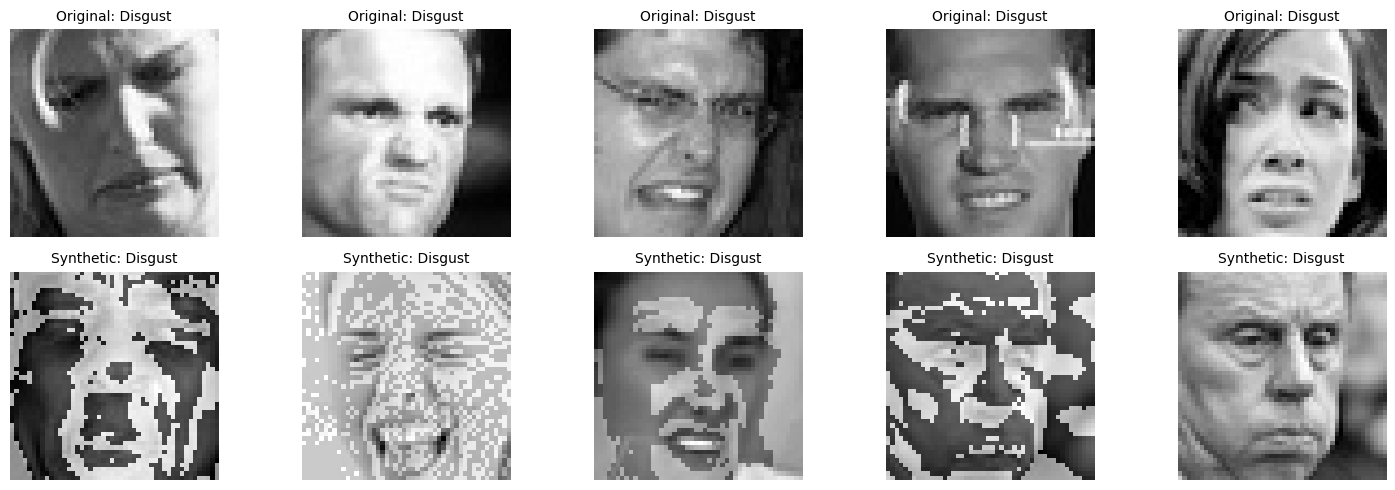

In [ ]:

y_combined_indices = np.arange(len(y_combined))

disgust_combined_indices = y_combined_indices[y_combined == "disgust"]

num_samples = 5
random_original_indices = np.random.choice(disgust_indices, num_samples, replace=False)

synthetic_disgust_indices = np.setdiff1d(disgust_combined_indices, disgust_indices)
num_oversampled = min(num_samples, len(synthetic_disgust_indices))
random_synthetic_indices = np.random.choice(synthetic_disgust_indices, num_oversampled, replace=False)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_original_indices):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(train_images[idx], cmap='gray')  # Original image
    plt.title("Original: Disgust", fontsize=10)
    plt.axis('off')

for i, idx in enumerate(random_synthetic_indices):
    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(X_combined[idx].reshape(train_images[0].shape), cmap='gray')  # Synthetic image
    plt.title("Synthetic: Disgust", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()


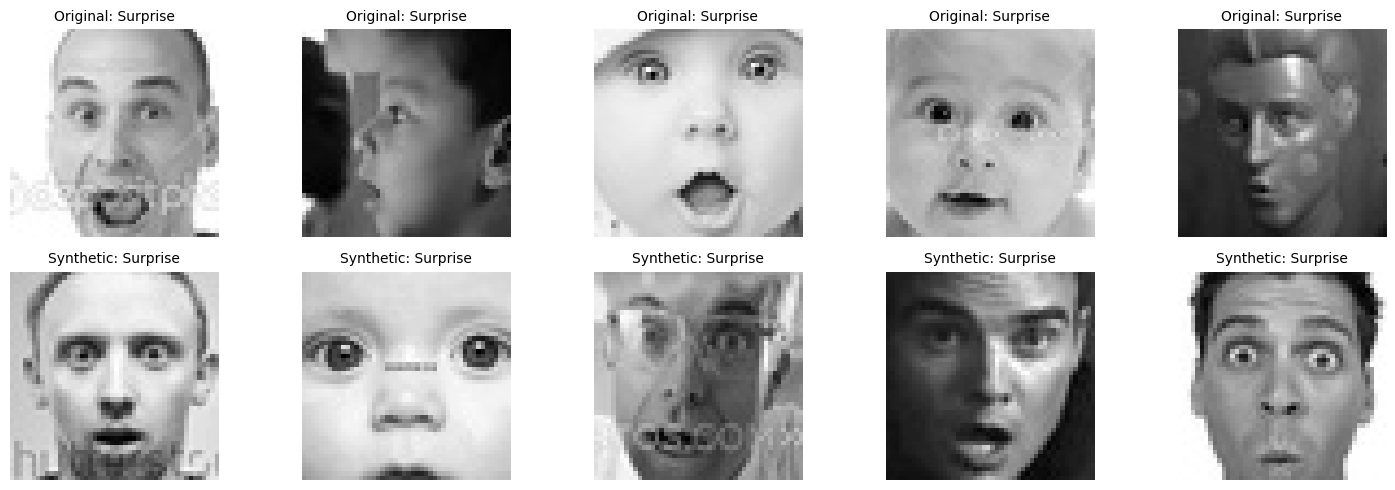

In [ ]:
surprise_combined_indices = np.where(y_combined == "surprise")[0]
num_samples = 5
random_original_indices = np.random.choice(surprise_indices, num_samples, replace=False)
synthetic_surprise_indices = np.setdiff1d(surprise_combined_indices, surprise_indices)
num_oversampled = min(num_samples, len(synthetic_surprise_indices))
random_synthetic_indices = np.random.choice(synthetic_surprise_indices, num_oversampled, replace=False)

plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_original_indices):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(train_images[idx], cmap='gray')
    plt.title("Original: Surprise", fontsize=10)
    plt.axis('off')

for i, idx in enumerate(random_synthetic_indices):
    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(X_combined[idx].reshape(train_images[0].shape), cmap='gray')
    plt.title("Synthetic: Surprise", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

Selecting a specific number of samples from the resampled data for certain classes to control the balance and size of the dataset.

In [ ]:
import numpy as np

max_surprise_samples = 500
max_disgust_samples = 2000

surprise_indices_combined = np.where(y_combined == "surprise")[0]
disgust_indices_combined = np.where(y_combined == "disgust")[0]

selected_surprise_indices = surprise_indices_combined[:max_surprise_samples]
selected_disgust_indices = disgust_indices_combined[:max_disgust_samples]


In [ ]:

image_shape = train_images.shape[1:]

X_surprise_reshaped = X_combined[selected_surprise_indices].reshape(-1, *image_shape)
X_disgust_reshaped = X_combined[selected_disgust_indices].reshape(-1, *image_shape)

final_train_images = np.concatenate([train_images, X_surprise_reshaped, X_disgust_reshaped], axis=0)

selected_surprise_labels = ["surprise"] * len(selected_surprise_indices)
selected_disgust_labels = ["disgust"] * len(selected_disgust_indices)

final_train_labels = np.concatenate([train_labels, selected_surprise_labels, selected_disgust_labels], axis=0)

print(final_train_images.shape, final_train_labels.shape)


(31209, 48, 48) (31209,)


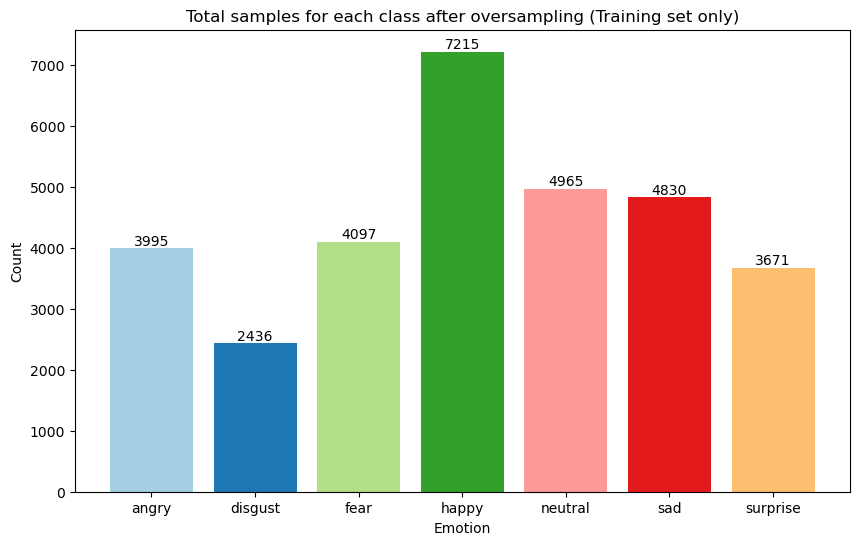

In [ ]:
train_class_counts = {class_name: np.sum(final_train_labels == class_name) for class_name in np.unique(final_train_labels)}

classes = list(train_class_counts.keys())
counts = list(train_class_counts.values())

plt.figure(figsize=(10, 6)) 
bars = plt.bar(classes, counts, color=plt.cm.Paired(np.arange(len(classes))))

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')

plt.title("Total samples for each class after oversampling (Training set only)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()


In [ ]:
final_train_images.shape, final_train_labels.shape


((31209, 48, 48), (31209,))

# PCA

In [ ]:
from sklearn.decomposition import PCA
from scipy.spatial import distance
import numpy as np
import plotly.graph_objs as go


In [ ]:
# Reshape the image data to a 2D array
num_samples, height, width = final_train_images.shape
X_train_flattened = final_train_images.reshape(num_samples, height * width)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_flattened)
X_train_pca.shape

(31209, 2)

In [ ]:
# Performing PCA with 3 components
pca = PCA(n_components=3)
X_train_pca_3d = pca.fit_transform(X_train_flattened)  # Make sure X_train_flattened is correctly defined

# Calculating the centroid of the main cluster
centroid = np.mean(X_train_pca_3d, axis=0)

# Calculating the distances from the centroid to each point
distances = distance.cdist([centroid], X_train_pca_3d, 'euclidean')[0]

# Defining a threshold for outlier detection, here at 99.5th percentile of distances
threshold = np.percentile(distances, 99.5)

# Identifying the outliers based on the threshold
outlier_indices = np.where(distances > threshold)[0]


Outliers for angry = 0
Outliers for disgust = 157
Outliers for fear = 0
Outliers for happy = 0
Outliers for neutral = 0
Outliers for sad = 0
Outliers for surprise = 0


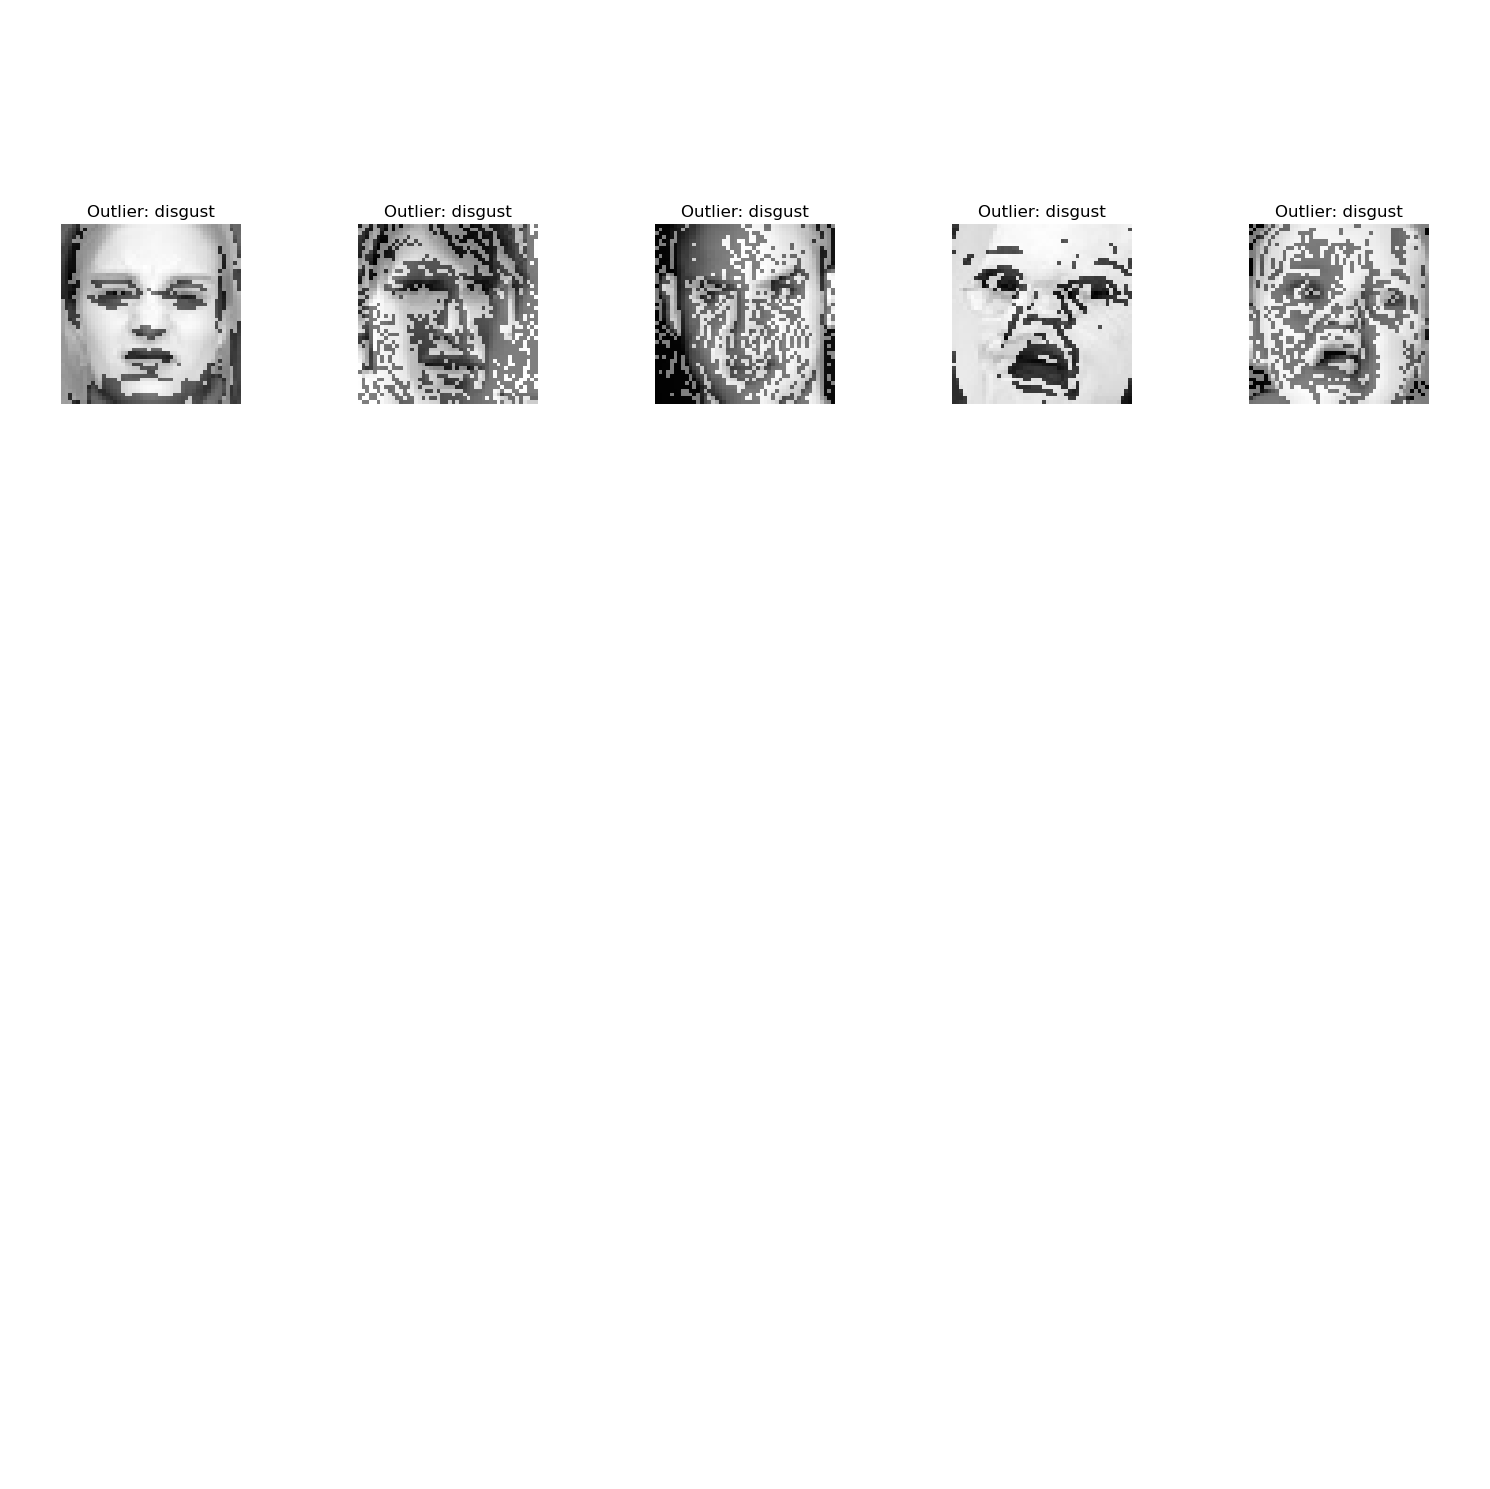

In [ ]:

class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
num_classes = len(class_names)
num_samples = 5 

fig, axes = plt.subplots(num_classes, num_samples, figsize=(15, 15), squeeze=False)  # Ensure axes is always 2D

for i, class_name in enumerate(class_names):
    class_indices = np.where(final_train_labels == class_name)[0]
    outlier_indices_for_class = np.intersect1d(class_indices, outlier_indices)  # Get outliers for the current class
    num_outliers = len(outlier_indices_for_class)
    
    print(f"Outliers for {class_name} = {num_outliers}")
    
    if num_outliers > num_samples:
        chosen_indices = np.random.choice(outlier_indices_for_class, num_samples, replace=False)
    else:
        chosen_indices = outlier_indices_for_class
    
    for j in range(num_samples):
        ax = axes[i, j]
        if j < len(chosen_indices): 
            outlier_idx = chosen_indices[j]
            image = final_train_images[outlier_idx].reshape(image_shape) 
            ax.imshow(image, cmap='gray')
            ax.set_title(f'Outlier: {class_name}')
        ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
final_train_images_cleaned = np.delete(final_train_images, outlier_indices, axis=0)
final_train_labels_cleaned = np.delete(final_train_labels, outlier_indices, axis=0)

final_train_images.shape, final_train_images_cleaned.shape,

((31209, 48, 48), (31052, 48, 48))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset


In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 6 * 6, 512)  # Adjust this depending on input size
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 128 * 6 * 6)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
class CNN2(nn.Module):
    def __init__(self, num_classes):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout2d(p=0.5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.dropout2 = nn.Dropout2d(p=0.5)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=5, padding=2)
        self.dropout3 = nn.Dropout2d(p=0.5)
        self.fc1 = nn.Linear(128 * 6 * 6, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.conv5(x)))
        x = F.relu(self.conv6(x))
        x = self.pool(x)
        x = self.dropout3(x)
        x = x.view(-1, 128 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
#training data
X_train_tensor = torch.tensor(final_train_images_cleaned)
X_train_tensor = X_train_tensor.float()
X_train_tensor = torch.unsqueeze(X_train_tensor, 1)

print(X_train_tensor.shape, X_train_tensor.dtype)


#testing data
X_test_tensor = torch.tensor(test_images)
X_test_tensor = X_test_tensor.float()
X_test_tensor = torch.unsqueeze(X_test_tensor, 1)

print(X_test_tensor.shape, X_test_tensor.dtype)

torch.Size([31052, 1, 48, 48]) torch.float32
torch.Size([7178, 1, 48, 48]) torch.float32


In [ ]:
#training data
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(final_train_labels_cleaned)
y_train_tensor = torch.tensor(y_train_encoded)

class_names = label_encoder.classes_
print(class_names)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

#testing data
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(test_labels)
y_test_tensor = torch.tensor(y_test_encoded)

class_names = label_encoder.classes_
print(class_names)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [ ]:
# Instantiate the model
num_classes = 7
model = CNN(num_classes)
model.to(device)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
num_epochs = 20
final_loss = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)
                
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels) 

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    final_loss.append(running_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')
        
    if epoch % 50 == 0:        
        model_name = "fer_model_"+ str(epoch)+ ".pth"
        torch.save(model.state_dict(), model_name)

# Save the final trained model
torch.save(model.state_dict(), 'fer_model_final.pth')

Epoch [1/20], Loss: 2.0237788613866456
Epoch [2/20], Loss: 1.8794872049936673
Epoch [3/20], Loss: 1.7795251482669898
Epoch [4/20], Loss: 1.533023104977043
Epoch [5/20], Loss: 1.326268262831239
Epoch [6/20], Loss: 1.1454943707011387
Epoch [7/20], Loss: 0.9595560006697563
Epoch [8/20], Loss: 0.7648403486495897
Epoch [9/20], Loss: 0.5658108090366075
Epoch [10/20], Loss: 0.43873832265853147
Epoch [11/20], Loss: 0.36256787624405784
Epoch [12/20], Loss: 0.2725939201661045
Epoch [13/20], Loss: 0.24571036011360425
Epoch [14/20], Loss: 0.22192450598300456
Epoch [15/20], Loss: 0.20345174559477397
Epoch [16/20], Loss: 0.1961447684709117
Epoch [17/20], Loss: 0.19620177277366416
Epoch [18/20], Loss: 0.16798743914575898
Epoch [19/20], Loss: 0.15468420628633303
Epoch [20/20], Loss: 0.16621829152990125


In [ ]:
# Plotting the final loss
fig = go.Figure(data=go.Scatter(y=final_loss, mode='lines'))
fig.update_layout(title='Training Loss over Epochs',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')
fig.show()

In [ ]:
correct, total = 0, 0

true_labels, predicted_labels = [], []

# Evaluate the model
model.eval()

# Iterate over the dataset or batches
for inputs, labels in test_loader:
    # Forward pass
    
    inputs, labels = inputs.to(device), labels.to(device)
    
    outputs = model(inputs)
    
    # Get predicted labels
    _, predicted = torch.max(outputs, 1)
    
    # Append true and predicted labels to lists
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())

    # Count total number of samples
    total += labels.size(0)
    
    # Count number of correct predictions
    correct += (predicted == labels).sum().item()

Accuracy: 0.50


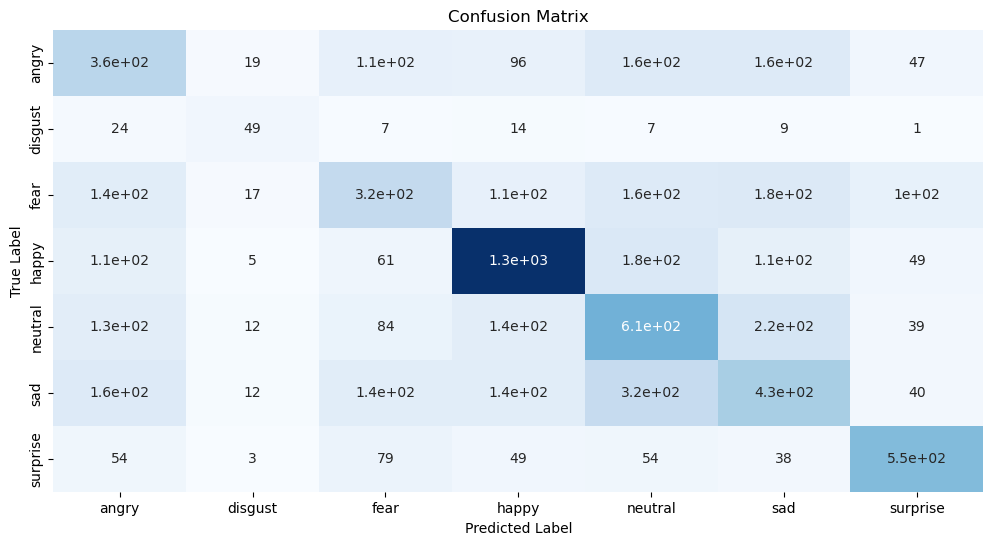

In [ ]:
# Calculate accuracy
accuracy = correct / total
print(f'Accuracy: {accuracy:.2f}')

# Get the original class names
class_names = label_encoder.classes_

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix with class names
plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix, annot=True, cbar=False, xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

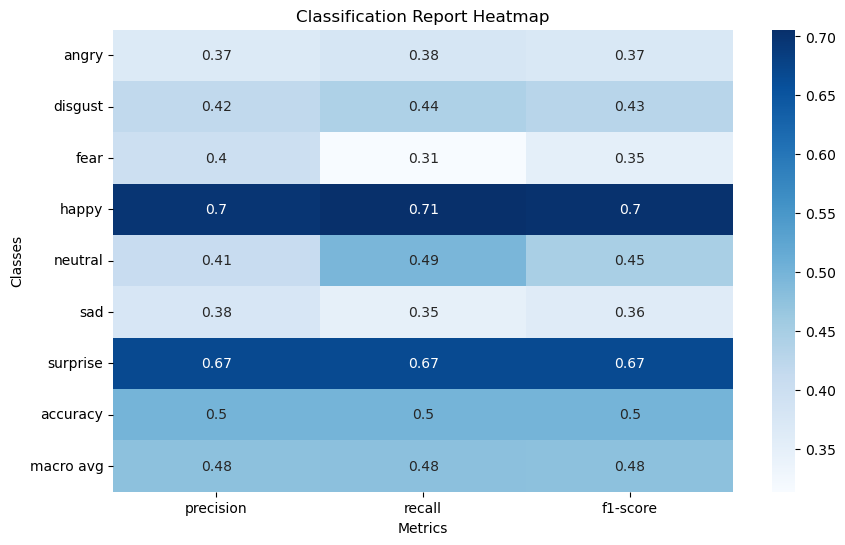

In [ ]:
# Get classification report
class_report = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()

print(class_report_df)

## Sign Language Detection

In [ ]:
csv  = pd.read_csv('sign_language_mnist/sign_mnist_train/sign_mnist_train.csv')

In [ ]:
print(csv.head(10))

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      3     107     118     127     134     139     143     146     150   
1      6     155     157     156     156     156     157     156     158   
2      2     187     188     188     187     187     186     187     188   
3      2     211     211     212     212     211     210     211     210   
4     13     164     167     170     172     176     179     180     184   
5     16     161     168     172     173     178     184     189     193   
6      8     134     134     135     135     136     137     137     138   
7     22     114      42      74      99     104     109     117     127   
8      3     169     174     176     180     183     185     187     188   
9      3     189     189     189     190     190     191     190     190   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     153  ...       207       207       207       207       206       206   
1     1

In [ ]:
csv.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,...,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000
mean,12.318813,145.419377,148.500273,151.247714,153.546531,156.210891,158.411255,160.472154,162.339683,163.954799,...,141.104863,147.495611,153.325806,159.125332,161.969259,162.736696,162.906137,161.966454,161.137898,159.824731
std,7.287552,41.358555,39.942152,39.056286,38.595247,37.111165,36.125579,35.016392,33.661998,32.651607,...,63.751194,65.512894,64.427412,63.708507,63.738316,63.444008,63.509210,63.298721,63.610415,64.396846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,121.000000,126.000000,130.000000,133.000000,137.000000,140.000000,142.000000,144.000000,146.000000,...,92.000000,96.000000,103.000000,112.000000,120.000000,125.000000,128.000000,128.000000,128.000000,125.500000
50%,13.000000,150.000000,153.000000,156.000000,158.000000,160.000000,162.000000,164.000000,165.000000,166.000000,...,144.000000,162.000000,172.000000,180.000000,183.000000,184.000000,184.000000,182.000000,182.000000,182.000000
75%,19.000000,174.000000,176.000000,178.000000,179.000000,181.000000,182.000000,183.000000,184.000000,185.000000,...,196.000000,202.000000,205.000000,207.000000,208.000000,207.000000,207.000000,206.000000,204.000000,204.000000
max,24.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


In [ ]:
labels = csv['label']

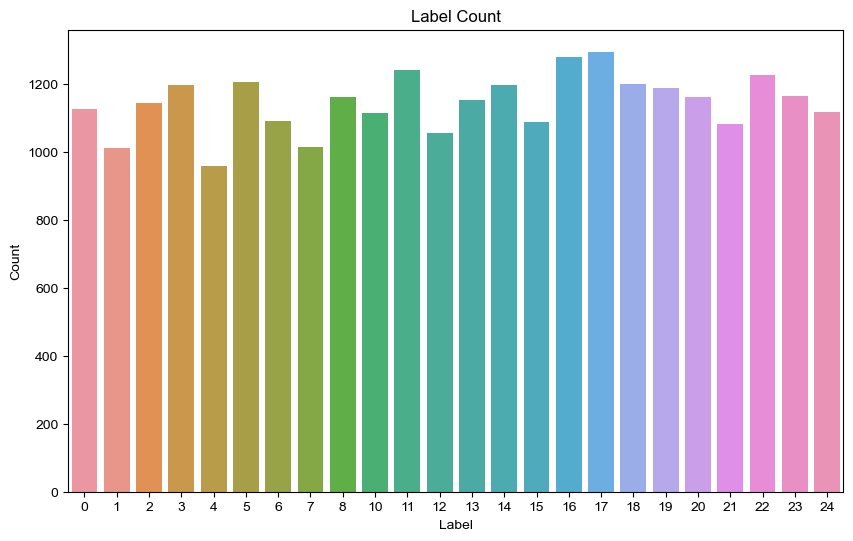

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=csv, x='label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Count')
sns.set_style('darkgrid')
plt.show()



In [ ]:
text="pixel"
images=torch.zeros((csv.shape[0],1))
for i in range(1,785):
    temp_text=text+str(i)
    temp=csv[temp_text]
    temp=torch.FloatTensor(temp).unsqueeze(1)
    images=torch.cat((images,temp),1)
images_final=torch.FloatTensor(images[:,1:]).view(-1,28,28)

Displaying Data:

Loop through the first 12 images and display it using Matplotlib.

Images are arranged in 4 rows of three columns each.

Images are resized to (224,224).


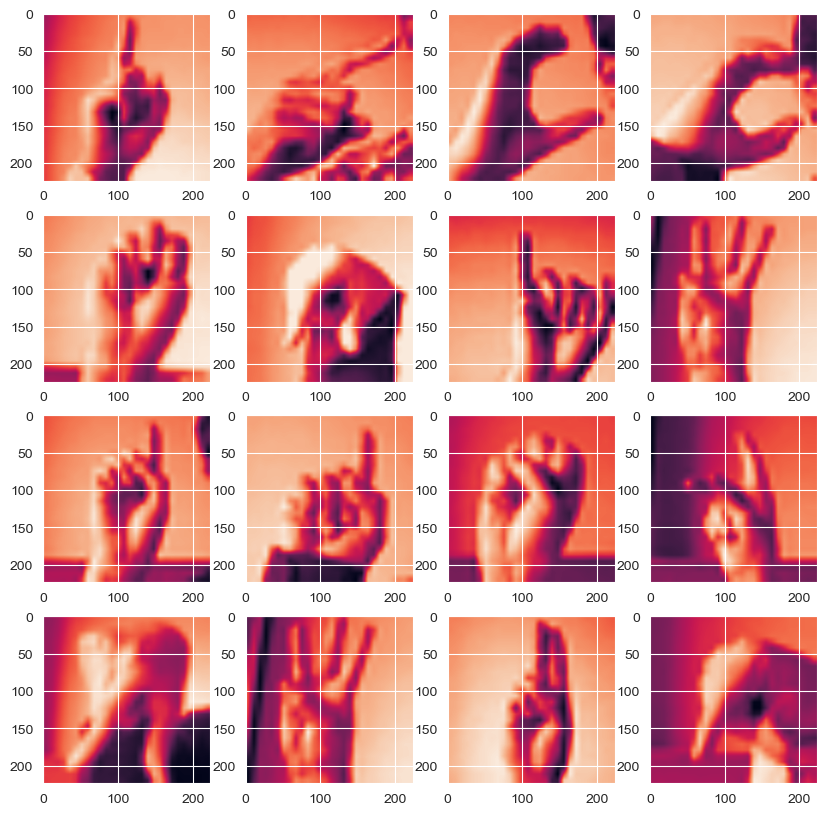

In [ ]:
fig=plt.figure(figsize=(10,10))
columns=4
rows=4
for i in range(16):
    img=images_final[i,:]
    img=img.numpy()
    img=cv2.resize(img,(224,224))
    fig.add_subplot(columns, rows, i + 1)
    plt.imshow(img)
plt.show()

#### Gesture Dataset for normalizing and resizing the hand gesture data

In [ ]:
class GestureDataset(Dataset):
    def __init__(self,csv,train=True):
        self.csv=pd.read_csv(csv)
        self.img_size=112
        self.train=train
        text="pixel"
        self.images=torch.zeros((self.csv.shape[0],1))
        for i in range(1,785):
            temp_text=text+str(i)
            temp=self.csv[temp_text]
            temp=torch.FloatTensor(temp).unsqueeze(1)
            self.images=torch.cat((self.images,temp),1)
        self.labels=self.csv['label']
        self.images=self.images[:,1:]
        self.images=self.images.view(-1,28,28)
        
    def __getitem__(self,index):
        img=self.images[index]
        img=img.numpy()
        img=cv2.resize(img,(self.img_size,self.img_size))
        tensor_image=torch.FloatTensor(img)
        tensor_image=tensor_image.unsqueeze(0)
        tensor_image /= 255.
        if self.train:
            return tensor_image,self.labels[index]
        else:
            return tensor_image
    def __len__(self):
        return self.images.shape[0]

#### Reading training and test dataset

In [ ]:
data=GestureDataset("sign_language_mnist/sign_mnist_train/sign_mnist_train.csv")
data_val=GestureDataset("sign_language_mnist/sign_mnist_test/sign_mnist_test.csv")

In [ ]:
train_loader=torch.utils.data.DataLoader(dataset=data,batch_size=128,shuffle=True)
val_loader=torch.utils.data.DataLoader(dataset=data_val,batch_size=64,shuffle=True)

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [ ]:
def validate(val_loader,model):
    model.eval()
    test_labels=[0]
    test_pred=[0]
    for i, (images,labels) in enumerate(val_loader):
        outputs=model(images.to(device))
        predicted = torch.softmax(outputs,dim=1)
        _,predicted=torch.max(predicted, 1)
        test_pred.extend(list(predicted.data.cpu().numpy()))
        test_labels.extend(list(labels.data.cpu().numpy()))

    test_pred=np.array(test_pred[1:])
    test_labels=np.array(test_labels[1:])
    correct=(test_pred==test_labels).sum()
    accuracy=correct/len(test_labels)
    f1_test=f1_score(test_labels,test_pred,average='weighted')
    return accuracy,f1_test 

### CNN and RNN for the hand gesture recognition

In [ ]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(CNNFeatureExtractor, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 28 * 28, 512),  
            nn.ReLU(),
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)  
        x = self.fc_layers(x)
        return x

class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNClassifier, self).__init__()
        self.feature_extractor = CNNFeatureExtractor()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        if x.dim() == 4:  
            x = x.unsqueeze(1)
        batch_size, seq_len, C, H, W = x.size()
        c_in = x.view(batch_size * seq_len, C, H, W)  
        c_out = self.feature_extractor(c_in) 
        r_in = c_out.view(batch_size, seq_len, -1) 
        r_out, (_, _) = self.lstm(r_in)
        out = self.fc(r_out[:, -1, :]) 
        return out

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = RNNClassifier(input_size=512, hidden_size=256, num_layers=2, num_classes=25)
model.to(device)


RNNClassifier(
  (feature_extractor): CNNFeatureExtractor(
    (conv_layers): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc_layers): Sequential(
      (0): Linear(in_features=50176, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (lstm): LSTM(512, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=25, bias=True)
)

In [ ]:
learning_rate=1e-3
start_epoch=0
end_epoch=20

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(end_epoch):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images.to(device))
        loss = criterion(outputs.to(device), labels.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        predicted = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(predicted, 1)
        f1 = f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='weighted')
    val_accuracy, val_f1 = validate(val_loader, model)
    print("Epoch [{}/{}], Training F1: {:.4f}, Validation Accuracy: {:.4f}, Validation F1: {:.4f}".format(epoch,end_epoch,f1,val_accuracy,val_f1))

Epoch [0/20], Training F1: 0.9144, Validation Accuracy: 0.7607, Validation F1: 0.7581
Epoch [1/20], Training F1: 1.0000, Validation Accuracy: 0.8395, Validation F1: 0.8376
Epoch [2/20], Training F1: 1.0000, Validation Accuracy: 0.8491, Validation F1: 0.8474
Epoch [3/20], Training F1: 1.0000, Validation Accuracy: 0.8555, Validation F1: 0.8537
Epoch [4/20], Training F1: 1.0000, Validation Accuracy: 0.8592, Validation F1: 0.8572
